## Content
* [Business Problem](#intro)
* [Data Used](#data)
* [Analysis](#analysis)
* [Conclusion](#conclude)

## Bussiness Problem <a name="intro"></a>

There is the requirement of Recommendation system for the visitors in an area. That system will later be integrated with mobile and web-based application. Currently, a POC is required to be done for a Orlando, Florida which is known for Amusement parks. This will help the visitors to figure out tha available options in the area. Later on it will be automated for other places. This will returned the list of top 5 options based on the options. For this POC, we will consider only the 5 categories - Resturants,Drinks, Parks and Others(it will include everything else).

## Data Used <a name="data"></a>

We will explore the offerings available in the area and try to figure out the most popular places in different categories

Data sources that will be used are:

- Foursqaure.api is used to get the information about the type of venues available for the given area(Orlando,Florida).
- Foursquare.api will be used to retrieve the records based on the popularity of the venue( this can be done by setting the parameter bool_popular = 1)
- Latitutde and Longitude details of the given area can be retrieved from Google Maps API.


### Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import folium 
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

### GoogleAPI key is saved in a local file  and loaded from there. Below code is performing that task. 
### This is required for security purpose.

In [2]:
#To load my google API key from a file
data = pd.read_csv('D:\study\coursera\capstone\Coursera_Capstone\google_api.txt', sep=" ", header=None)
google_api_key=data[0][0]

### Retrieving Latitude and Longitude of university of Orlando, Florida using google API

In [3]:

address= 'orlando,Florida'
url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(google_api_key, address)
response = requests.get(url).json()

#print('Google Maps API JSON result =>', response)
results = response['results']
geographical_data = results[0]['geometry']['location'] # get geographical coordinates
lat = geographical_data['lat']
long = geographical_data['lng']
print("cordinates are:{},{}".format(lat,long))

cordinates are:28.5383355,-81.3792365


### FoursquareI key is saved in a local file  and loaded from there. Below code is performing that task. 
### This is required for security purpose.

In [4]:
# Foursquare API client ID, Client_secret and Version
data = pd.read_csv('D:\study\coursera\capstone\Coursera_Capstone\\foursquare_api.txt', sep=" ", header=None)
CLIENT_ID = data[0][0] #Foursquare ID
CLIENT_SECRET=data[0][1] #Foursquare Secret Key
VERSION = '20190101' # Foursquare API version
radius= 5000
limit=10000
bool_popular=1
#print("id: {},secret: {}, version: {}".format(CLIENT_ID,CLIENT_SECRET,VERSION))

## Retrieving Data from the foursquare API based on the popularity of the venue

In [5]:
url= 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,radius,limit,bool_popular)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e2b5974aba297001b457df7'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Orlando',
  'headerFullLocation': 'Orlando',
  'headerLocationGranularity': 'city',
  'totalResults': 234,
  'suggestedBounds': {'ne': {'lat': 28.583335545000043,
    'lng': -81.32810827632807},
   'sw': {'lat': 28.493335454999954, 'lng': -81.43036472367194}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bdad4aaa8d976b0738e0cb5',
       'name': 'Amway Center',
       'location': {'address': '400 W Church St',
        'crossStreet': 'btwn Division & Hughey',
        'lat': 28.53921048743448,
        'lng': -81.38379844002355,
  

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues['categories'].unique())
orlando_data=nearby_venues
nearby_venues.head()


['Basketball Stadium' 'Park' 'Stadium' 'Grocery Store'
 'American Restaurant' 'Big Box Store' 'Soccer Stadium'
 'Convenience Store' 'Hotel' 'Theater' 'Fast Food Restaurant' 'Butcher'
 'Wine Shop' 'Bar' 'Gym / Fitness Center' 'Science Museum' 'Gym' 'Library'
 'Restaurant' 'Mexican Restaurant' 'Market' 'French Restaurant'
 'Italian Restaurant' 'Taco Place' 'Arts & Crafts Store' 'Coffee Shop'
 'Beer Bar' 'Burger Joint' 'Pizza Place' 'Gay Bar' 'Tapas Restaurant'
 'Bookstore' 'Pharmacy' 'Fabric Shop' 'Garden' 'Deli / Bodega'
 'Cocktail Bar' 'Sporting Goods Shop' 'Asian Restaurant' 'Golf Course'
 'Liquor Store' 'Nightclub' 'Ice Cream Shop' 'Japanese Restaurant'
 'Cuban Restaurant' 'Bagel Shop' 'Steakhouse'
 'Vegetarian / Vegan Restaurant' 'Farmers Market' 'Adult Boutique' 'Diner'
 'Ramen Restaurant' 'BBQ Joint' 'Tea Room' 'Pub'
 'Latin American Restaurant' 'Cosmetics Shop' 'Breakfast Spot'
 'Movie Theater' 'Gastropub' 'Brewery']


,name,categories,lat,lng
0,Amway Center,Basketball Stadium,28.539210,-81.383798
1,Lake Eola Park,Park,28.543931,-81.371308
2,Camping World Stadium,Stadium,28.539027,-81.402769
3,Publix,Grocery Store,28.510116,-81.373351
4,Vanbarry's Public House,American Restaurant,28.497844,-81.376236


## Show all the venues on the map which are retrieved from foursquare into 4 broad categories. Restaurants in blue color, Drinks in red color, Parks in green color and  Others in yellow color are marked on the map

In [8]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [11]:
orlando_grouped=nearby_venues.groupby('categories').mean().reset_index()
orlando_grouped

,categories,lat,lng
0,Adult Boutique,28.566927,-81.402679
1,American Restaurant,28.538153,-81.374138
2,Arts & Crafts Store,28.551501,-81.348343
3,Asian Restaurant,28.557147,-81.355149
4,BBQ Joint,28.563114,-81.364667
5,Bagel Shop,28.520039,-81.376156
6,Bar,28.547452,-81.369452
7,Basketball Stadium,28.539210,-81.383798
8,Beer Bar,28.542954,-81.371517
9,Big Box Store,28.515673,-81.379970


In [87]:
counting_venues=nearby_venues.set_index(["categories","name"]).count(level="categories")
counting_venues.drop(columns=['lat','lng'],inplace=True)
counting_venues.rename(columns={"Main_Category":"count"},inplace=True)
counting_venues.reset_index(level=0, inplace=True)
counting_venues.sort_values(by=['count'], ascending=False,inplace=True)
counting_venues=counting_venues.head(20)

In [75]:
counting_venues.dtypes

categories    object
count          int64
dtype: object

## Graphical Representation of count of different choices availble in different category

In [24]:
import matplotlib.pyplot as plt; plt.rcdefaults()import matplotlib.pyplot as plt

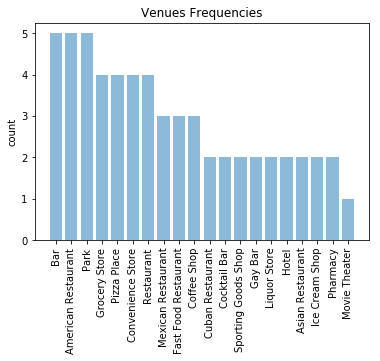

In [97]:
x=np.arange(len(counting_venues["categories"]))

plt.bar(x,counting_venues["count"], align='center', alpha=0.5)
plt.xticks(x, counting_venues["categories"],rotation=90)
plt.ylabel('count')
plt.title('Venues Frequencies')

plt.show()

It is noticible that restaurants are scattered into many categories ( american, mexican etc.). Below we will merge all of them under a new category.


## Creating a new column for the generic category

In [89]:

df1=orlando_grouped
nearby_venues['Main_Category']=""

In [90]:
nearby_venues['Main_Category']=""
nearby_venues.loc[nearby_venues['categories'].str.contains('Restaurant'), ['Main_Category']] ="Restaurant"
nearby_venues.loc[nearby_venues['categories'].str.contains('Park'), ['Main_Category']] ="Park"
nearby_venues.loc[nearby_venues['categories'].str.contains('Bar'), ['Main_Category']] ="Drinks"
nearby_venues.loc[nearby_venues['Main_Category']=="", ['Main_Category']]="Other"

In [91]:
nearby_venues.head(10)

,name,categories,lat,lng,Main_Category
0,Amway Center,Basketball Stadium,28.539210,-81.383798,Other
1,Lake Eola Park,Park,28.543931,-81.371308,Park
2,Camping World Stadium,Stadium,28.539027,-81.402769,Other
3,Publix,Grocery Store,28.510116,-81.373351,Other
4,Vanbarry's Public House,American Restaurant,28.497844,-81.376236,Restaurant
5,Target,Big Box Store,28.515673,-81.379970,Other
6,Orlando City Stadium,Soccer Stadium,28.541138,-81.388875,Other
7,Wawa,Convenience Store,28.508871,-81.376967,Other
8,Wawa,Convenience Store,28.552839,-81.334017,Other
9,Publix,Grocery Store,28.541963,-81.372978,Other


In [95]:
to_grouped=nearby_venues.groupby('Main_Category').mean().reset_index()
to_grouped

,Main_Category,lat,lng
0,Drinks,28.546456,-81.370529
1,Other,28.545188,-81.365450
2,Park,28.542414,-81.360956
3,Restaurant,28.544256,-81.362349


In [18]:
to_grouped.shape

(4, 3)

In [101]:
main_category_count=nearby_venues.groupby('Main_Category').count()

main_category_count.drop(columns=['categories','lat','lng'],inplace=True)
main_category_count.rename(columns={"name":"count"},inplace=True)
main_category_count.reset_index(level=0, inplace=True)
main_category_count.sort_values(by=['count'], ascending=True,inplace=True)

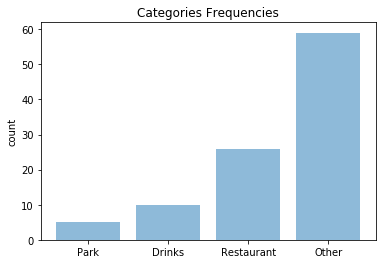

In [102]:
x=np.arange(len(main_category_count["Main_Category"]))

plt.bar(x,main_category_count["count"], align='center', alpha=0.5)
plt.xticks(x, main_category_count["Main_Category"])
plt.ylabel('count')
plt.title('Categories Frequencies')

plt.show()

In [103]:
# one hot encoding
to_onehot = pd.get_dummies(nearby_venues[['name']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Main_Category'] = nearby_venues['Main_Category'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]
to_grouped=to_onehot.groupby('Main_Category').mean().reset_index()


## Analysis<a name="analysis"></a>

We will be fetching top 5 most popular venues in different categories. This will help to point out the most happening place in Orlando as per the ratings available on foursquare.com

## Fetching the list of top 5 venues in different categories

In [104]:
num_top_venues = 5
orlando = pd.DataFrame(columns = ['venue','freq'])
for hood in to_grouped['Main_Category']:
    print("----"+hood+"----")
    temp = to_grouped[to_grouped['Main_Category'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    if orlando.empty:
        orlando=temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    else:
        orlando=orlando.append(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues),ignore_index = True)
    print('\n')
    
orlando['Main_Category']=""
for i in range(20):
    if i>=0 and i<5:
        #print("Drinks:",orlando.iloc[i])
        orlando.loc[orlando['venue'] == orlando.iloc[i][0], ['Main_Category']] ="Drinks"  
    elif i>=5 and i<10:
        orlando.loc[orlando['venue'] == orlando.iloc[i][0], ['Main_Category']] ="Other" 
    elif i>=10 and i<15:
        orlando.loc[orlando['venue'] == orlando.iloc[i][0], ['Main_Category']] ="Park" 
    elif i>=15 and i<20:
        orlando.loc[orlando['venue'] == orlando.iloc[i][0], ['Main_Category']] ="Restaurant"         
        
    


----Drinks----
               venue  freq
0         Lucky Lure   0.1
1  The Hammered Lamb   0.1
2    Southern Nights   0.1
3          Roque Pub   0.1
4          Stonewall   0.1


----Other----
                         venue  freq
0                       Publix  0.05
1                         Wawa  0.05
2      ABC Fine Wine & Spirits  0.03
3                    Starbucks  0.03
4  The Country Club Of Orlando  0.02


----Park----
                     venue  freq
0      Lake Underhill Park   0.2
1           Lake Eola Park   0.2
2          Lake Davis Park   0.2
3             Delaney Park   0.2
4  Orlando Loch Haven Park   0.2


----Restaurant----
                        venue  freq
0               Tijuana Flats  0.08
1      Chipotle Mexican Grill  0.08
2                 Chick-fil-A  0.08
3               Gringos Locos  0.04
4  Firebirds Wood Fired Grill  0.04




In [105]:
final_df= pd.merge(left=orlando, right=orlando_data, left_on="venue", right_on="name")
final_df.drop(columns=['freq','Main_Category_y'],inplace=True)
final_df.rename(columns={"Main_Category_x":"Main_Category"},inplace=True)
final_df.head()

,venue,Main_Category,name,categories,lat,lng
0,Lucky Lure,Drinks,Lucky Lure,Bar,28.565406,-81.372739
1,The Hammered Lamb,Drinks,The Hammered Lamb,Bar,28.562665,-81.372963
2,Southern Nights,Drinks,Southern Nights,Gay Bar,28.539104,-81.351548
3,Roque Pub,Drinks,Roque Pub,Bar,28.523511,-81.344037
4,Stonewall,Drinks,Stonewall,Gay Bar,28.540306,-81.390676


In [106]:
map_orlando = folium.Map(location=[lat,long], zoom_start=13)

# add markers to map
for lat, lng, name, Main_Category in zip(orlando_data['lat'], orlando_data['lng'], orlando_data['name'], orlando_data['Main_Category']):
    label = '{}, {}'.format(name, Main_Category)
    label = folium.Popup(label, parse_html=True)
    if Main_Category is "Drinks":
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=label,
            tooltip=label,
            color='red',
            fill=False,
            fill_color='#3186cc',
            fill_opacity=0.8,
            parse_html=False).add_to(map_orlando)  
    elif Main_Category is "Restaurant":
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=label,
            color='blue',
            fill=False,
            fill_color='#3186cc',
            fill_opacity=0.8,
            parse_html=False).add_to(map_orlando) 
    elif Main_Category is "Park":
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=label,
            color='green',
            fill=False,
            fill_color='#3186cc',
            fill_opacity=0.8,
            parse_html=False).add_to(map_orlando)     
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=label,
            color='yellow',
            fill=False,
            fill_color='#3186cc',
            fill_opacity=0.8,
            parse_html=False).add_to(map_orlando)        
    
map_orlando 

#### Finally we retrieved top 5 places in different categories for a given area. This will help visitors to narrow down their options.

## Showing the top 5 venues in the 4 categories on the map

In [107]:
map_florida = folium.Map(location=[lat,long],tiles='Stamen Terrain', zoom_start=13)

# add markers to map
for lat, lng, name, Main_Category in zip(final_df['lat'], final_df['lng'], final_df['name'], final_df['Main_Category']):
    label = '{}, {}'.format(name, Main_Category)
    label = folium.Popup(label, parse_html=True)
    if Main_Category is "Drinks":
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=label,
            tooltip=label,
            color='red',
            fill=False,
            fill_color='#3186cc',
            fill_opacity=0.8,
            parse_html=False).add_to(map_florida)  
    elif Main_Category is "Restaurant":
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=label,
            color='blue',
            fill=False,
            fill_color='#3186cc',
            fill_opacity=0.8,
            parse_html=False).add_to(map_florida) 
    elif Main_Category is "Park":
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=label,
            color='green',
            fill=False,
            fill_color='#3186cc',
            fill_opacity=0.8,
            parse_html=False).add_to(map_florida)     
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=label,
            color='yellow',
            fill=False,
            fill_color='#3186cc',
            fill_opacity=0.8,
            parse_html=False).add_to(map_florida)        
    
map_florida 

## Conclusion<a name="conclude"></a>

This will help vistors to narrow down the area and places based on their interest. Adding this functionality to the application will be useful for the viewers. This will help them to make the informed decision.In return application and website will be get good traffic which will help in revenue generation.